In [23]:
!pip install kagglehub

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("preethamgouda/banglore-city-traffic-dataset")

df = pd.read_csv(path + "/Banglore_traffic_Dataset.csv")
df.head()

Using Colab cache for faster access to the 'banglore-city-traffic-dataset' dataset.
Path to dataset files: /kaggle/input/banglore-city-traffic-dataset

Dataset shape: (8936, 16)


,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


Congestion Level distribution:
Type: float64
Min: 5.160279008043586, Max: 100.0
Mean: 80.82

First 10 values: [100.0, 100.0, 28.34799386357647, 100.0, 100.0, 100.0, 100.0, 79.03882287608127, 78.97959595139889, 97.67246206775482]

CONGESTION CATEGORIES CREATED:
0 = Low (< 40%)
1 = Medium (40-70%)
2 = High (>= 70%)

Category distribution:
Congestion_Category
0     758
1    1839
2    6339
Name: count, dtype: int64


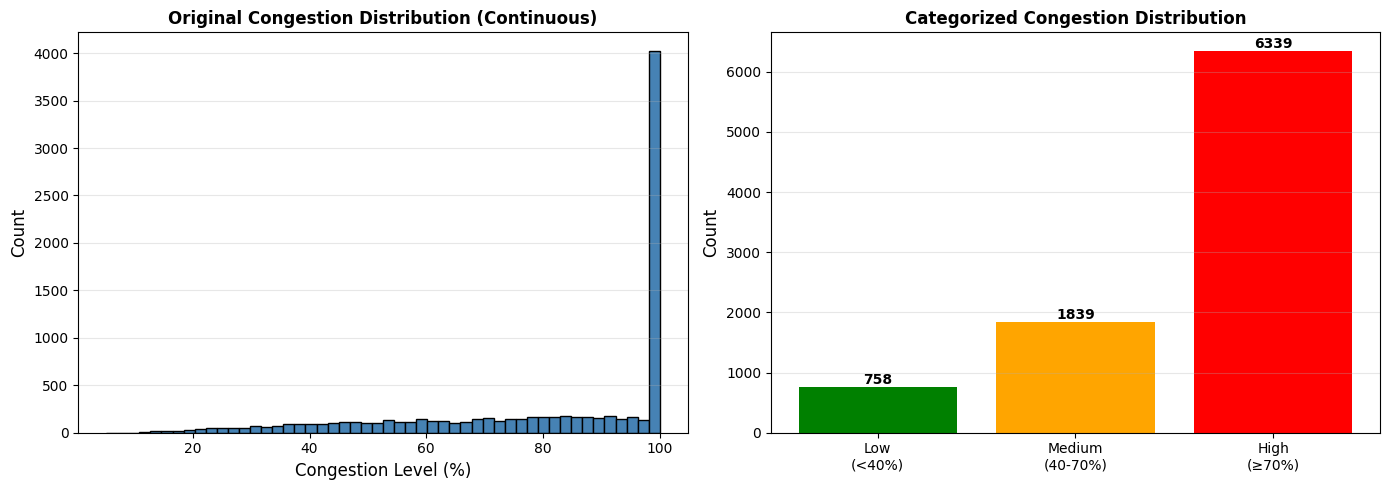

In [26]:
def categorize_congestion(value):
    if value < 40:
        return 0
    elif value < 70:
        return 1
    else:
        return 2

df['Congestion_Category'] = df['Congestion Level'].apply(categorize_congestion)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Congestion Level'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Congestion Level (%)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Original Congestion Distribution (Continuous)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

category_names = ['Low\n(<40%)', 'Medium\n(40-70%)', 'High\n(≥70%)']
counts = df['Congestion_Category'].value_counts().sort_index()
axes[1].bar(category_names, counts.values, color=['green', 'orange', 'red'])
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Categorized Congestion Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [27]:
df = df.dropna()
df = df.drop_duplicates()
df = df.drop(columns=["Date"])

df["Roadwork and Construction Activity"] = (
    df["Roadwork and Construction Activity"]
    .str.strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
)

df.info()

✅ Data cleaned
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Area Name                           8936 non-null   object 
 1   Road/Intersection Name              8936 non-null   object 
 2   Traffic Volume                      8936 non-null   int64  
 3   Average Speed                       8936 non-null   float64
 4   Travel Time Index                   8936 non-null   float64
 5   Congestion Level                    8936 non-null   float64
 6   Road Capacity Utilization           8936 non-null   float64
 7   Incident Reports                    8936 non-null   int64  
 8   Environmental Impact                8936 non-null   float64
 9   Public Transport Usage              8936 non-null   float64
 10  Traffic Signal Compliance           8936 non-null   float64
 11  Parking Usage               

In [28]:
y = df["Congestion_Category"].copy()

X = df.drop(columns=[
    "Congestion Level",
    "Congestion_Category",
    "Environmental Impact",
    "Area Name",
    "Road/Intersection Name",
])

X = pd.get_dummies(X, columns=["Weather Conditions"], drop_first=True)

print("Shape:", X.shape)

Features used: ['Traffic Volume', 'Average Speed', 'Travel Time Index', 'Road Capacity Utilization', 'Incident Reports', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Roadwork and Construction Activity', 'Weather Conditions_Fog', 'Weather Conditions_Overcast', 'Weather Conditions_Rain', 'Weather Conditions_Windy']
Shape: (8936, 14)

Target distribution:
Congestion_Category
0     758
1    1839
2    6339
Name: count, dtype: int64

0 = Low congestion (<40%)
1 = Medium congestion (40-70%)
2 = High congestion (≥70%)


In [29]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

Training set: (7148, 14)
Test set: (1788, 14)

Class distribution in train set:
Congestion_Category
2    5071
1    1471
0     606
Name: count, dtype: int64


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print("Logistic Regression")
print(f"Accuracy: {lr_acc:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

LOGISTIC REGRESSION
Accuracy: 0.9441
F1-Score: 0.9441

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       152
           1       0.86      0.86      0.86       368
           2       0.98      0.98      0.98      1268

    accuracy                           0.94      1788
   macro avg       0.89      0.90      0.90      1788
weighted avg       0.94      0.94      0.94      1788



In [31]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print("Random Forest")
print(f"Accuracy: {rf_acc:.4f}")
print(f"F1-Score: {rf_f1:.4f}")

RANDOM FOREST CLASSIFIER
Accuracy: 0.9463
F1-Score: 0.9465

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       152
           1       0.87      0.87      0.87       368
           2       0.98      0.98      0.98      1268

    accuracy                           0.95      1788
   macro avg       0.90      0.91      0.90      1788
weighted avg       0.95      0.95      0.95      1788



In [32]:
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=20,
    subsample=0.8,
    random_state=42
)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_pred)
gbc_f1 = f1_score(y_test, gbc_pred, average='weighted')

print("Gradient Boosting")
print(f"Accuracy: {gbc_acc:.4f}")
print(f"F1-Score: {gbc_f1:.4f}")

GRADIENT BOOSTING CLASSIFIER
Accuracy: 0.9418
F1-Score: 0.9422

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       152
           1       0.85      0.87      0.86       368
           2       0.98      0.97      0.98      1268

    accuracy                           0.94      1788
   macro avg       0.89      0.90      0.89      1788
weighted avg       0.94      0.94      0.94      1788



In [33]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf_clf),
        ('gbc', gbc)
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred, average='weighted')

print("Voting Ensemble")
print(f"Accuracy: {voting_acc:.4f}")
print(f"F1-Score: {voting_f1:.4f}")

VOTING ENSEMBLE (LR + RF + GBC)
Accuracy: 0.9446
F1-Score: 0.9449

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       152
           1       0.86      0.87      0.87       368
           2       0.98      0.98      0.98      1268

    accuracy                           0.94      1788
   macro avg       0.90      0.90      0.90      1788
weighted avg       0.95      0.94      0.94      1788



In [34]:
results = {
    'Logistic Regression': {'Accuracy': lr_acc, 'F1': lr_f1},
    'Random Forest': {'Accuracy': rf_acc, 'F1': rf_f1},
    'Gradient Boosting': {'Accuracy': gbc_acc, 'F1': gbc_f1},
    'Voting Ensemble': {'Accuracy': voting_acc, 'F1': voting_f1}
}

results_df = pd.DataFrame(results).T
print(results_df)


MODEL COMPARISON
                     Accuracy        F1
Logistic Regression  0.944072  0.944148
Random Forest        0.946309  0.946535
Gradient Boosting    0.941834  0.942247
Voting Ensemble      0.944631  0.944860

🏆 Best Model: Random Forest (Accuracy: 0.9463)


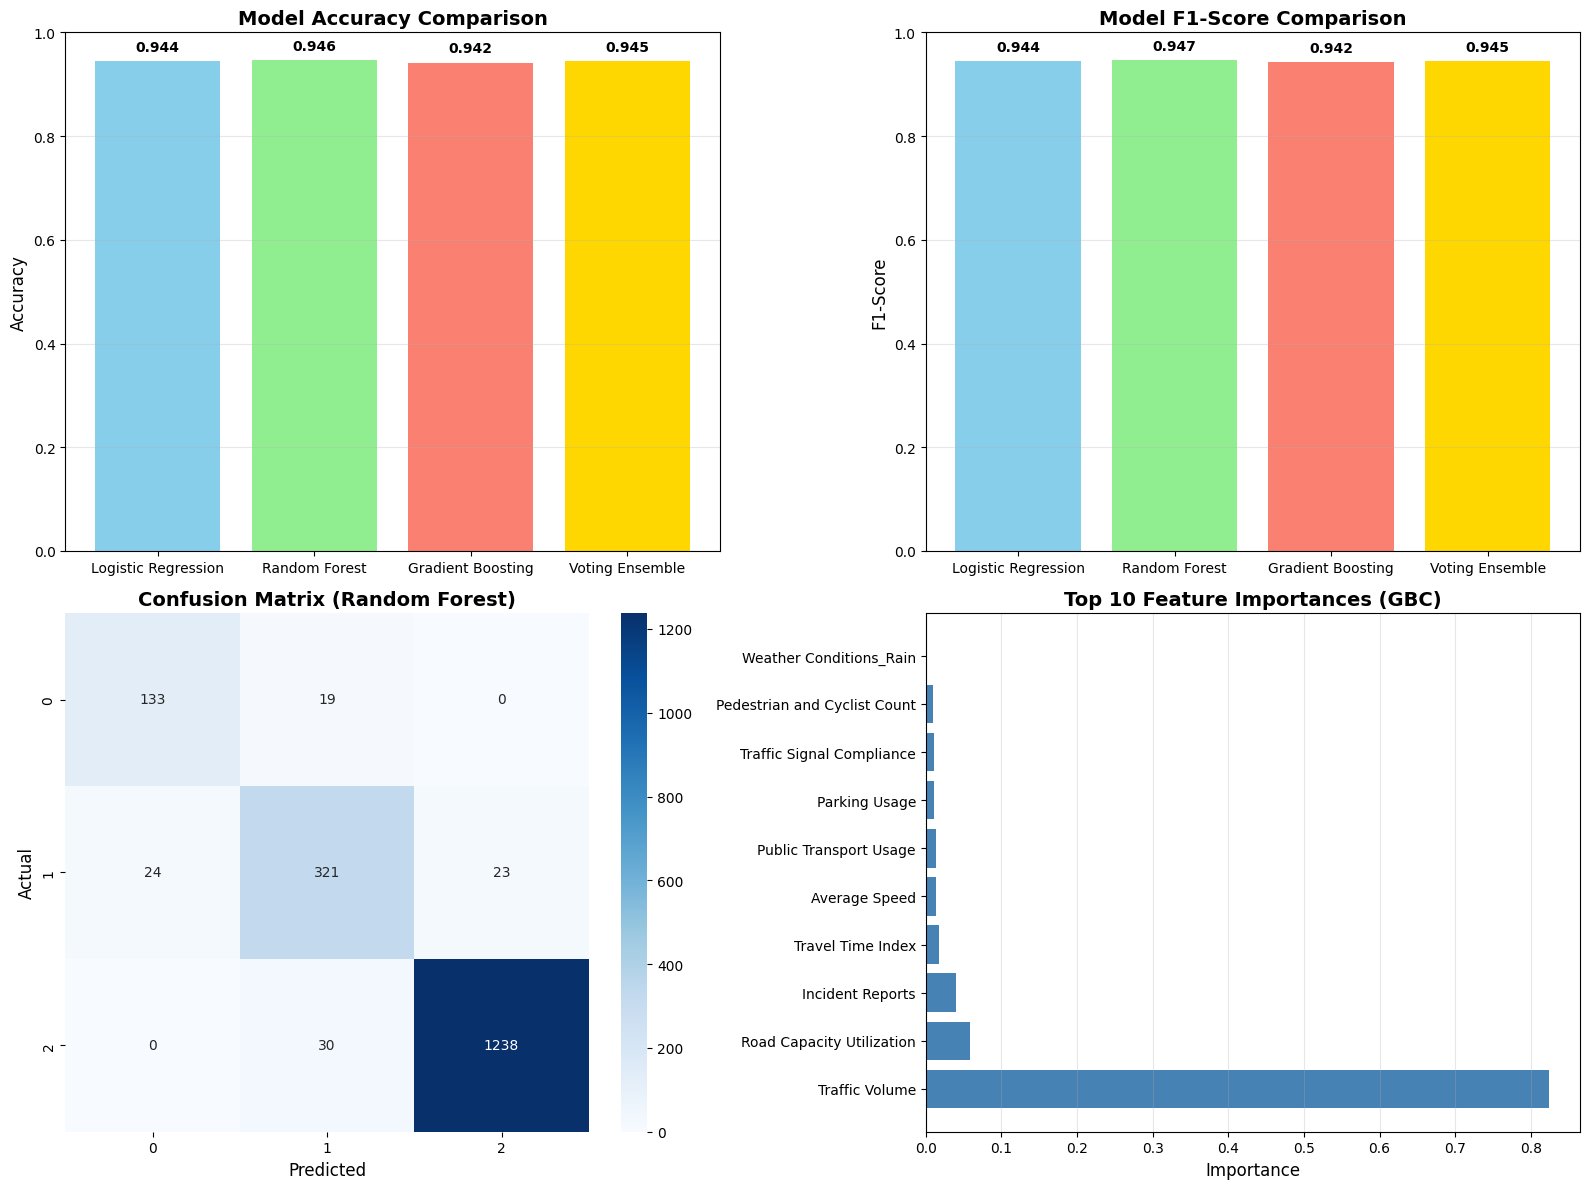

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_names]
f1_scores = [results[m]['F1'] for m in model_names]

axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[0, 1].bar(model_names, f1_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

cm = confusion_matrix(y_test, voting_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

top_features = pd.Series(gbc.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
axes[1, 1].barh(top_features.index, top_features.values, color='steelblue')
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
import joblib

joblib.dump(rf_clf, 'congestion_model.joblib')

sample = X_test.iloc[0:1]
pred = rf_clf.predict(sample)[0]
actual = y_test.iloc[0]

category_map = {0: 'Low', 1: 'Medium', 2: 'High'}
print(f"Predicted: {category_map[pred]}")
print(f"Actual: {category_map[actual]}")

✅ Best model (Random Forest) saved as 'congestion_model.joblib'

EXAMPLE PREDICTION
Predicted Congestion: Medium (1)
Actual Congestion: Medium (1)
Match: ✅
